# **MODELAGEM E ESTIMATIVA DOS PARÂMETROS CINÉTICOS PARA PRODUÇÃO DE AMOXILINA**
### ***POR SÍNTESE ENZIMÁTICA EM BIORREATOR BATELADA E BATELADA ALIMENTADA***

In [3]:
#%pip install openpyxl
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import random
import scipy
import glob
import os

### Importando dados

In [4]:
CIs = []
def convert_ci(ci):
    if type(ci) == str:
        ci_list = [float(i) for i in ci.split('_')]
        return ci_list
    else:
        ci_str = str(ci[0]) + '_' + str(ci[1]) + '_' + str(ci[2]) + '_' + str(ci[3])
        return ci_str
def import_dfs():
    # Path to the folder containing CSV files
    folder_path = '../data/'

    # Get a list of all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    # Initialize an empty list to hold dataframes
    data_frames = {}

    # Read the first CSV file to establish the schema
    schema = ['ester_mm', 'amox_mm', 'apa_mm', 'aoh_mm','apa_t']
    all_times = []
    # Load each remaining CSV file, reorder columns, and append to the list
    for file in csv_files:
        df = pd.read_csv(file)  
        print(file)
        df = df[schema]  # Reorder columns to match the schema
        print(df['apa_t'].max())
        all_times.append(df['apa_t'].to_list())
        ci = df.iloc[0,:4].to_numpy()
        data_frames[convert_ci(ci)] = df
        CIs.append(convert_ci(ci))
    
    csv_files = [name.split('\\')[-1].rstrip('.csv') for name in csv_files]

    return data_frames,csv_files,all_times
data_frames,file_list,all_times = import_dfs()

print(data_frames.keys())
print(data_frames[CIs[0]].columns)
print(file_list)
print(CIs)


../data\25.45nh60ab20.csv
490.0
../data\25.46nh30ab30.csv
490.0
../data\25.47nh5ab80.csv
240.0
../data\5.100nh40ab80.csv
600.0
../data\5.102nh20ab40.csv
540.0
../data\5.103nh40ab30.csv
540.0
../data\5.106nh100ab40.csv
360.0
../data\5.107nh55ab55.csv
50.0
../data\5.109nh5ab55.csv
60.0
../data\5.110nh10ab55.csv
60.0
../data\5.112nh78ab35.csv
360.0
../data\5.48nh20ab80.csv
60.0
../data\5.80nh12ab40.csv
410.0
../data\5.81nh5ab30.csv
285.0
../data\nh60ab80.csv
600.0
dict_keys(['20.0_0.0_60.0_0.0', '30.0_0.0_30.0_0.0', '80.0_0.0_5.0_0.0', '80.0_0.0_40.0_0.0', '40.5_0.0_21.75_3.372620126926563', '30.4_0.0_43.0_2.55', '40.038986354775815_0.0640149834167829_100.04518072289156_1.4210854715202004', '55.0_0.0_55.0_0.623377', '55.0_0.0_5.0_0.0', '55.0_0.0_10.0_0.0', '32.5_0.0_78.0_2.5', '80.0_0.0_20.0_0.0', '38.75_0.0_12.0_1.4', '30.0_0.0_5.0_0.0', '80.0_0.0_60.0_0.0'])
Index(['ester_mm', 'amox_mm', 'apa_mm', 'aoh_mm', 'apa_t'], dtype='object')
['25.45nh60ab20', '25.46nh30ab30', '25.47nh5ab80', '5.

### Model

In [5]:
def enzymic_amox(t,y, 
k2,
k3,
k4,
KS,
KP,
KN,
kmenos4,
):
    Cez = 1
    CAB = y[0]
    CAN = y[1]
    CNH = y[2]
    CAOH = y[3]

    # fixed parameter
    k5 = 0.150

    RP = (Cez)/(k3 * KN + k4 * CNH + k5 * CNH) * (((k2 * k4 * CAB * CNH)/ (KS)) - ((kmenos4 * CAN * (k3 * KN + k5 * CNH))/KP))
    RB = (Cez * (k3 * KN + k5 * CNH) / (k3 * KN + k4 * CNH + k5 * CNH)) * (((k2 * CAB)/KS) - ((kmenos4 * CAN) / KP))
    RS = -(RP + RB)
    RNu = -(RP)

    dy = np.zeros(4)

    dy[0] =  RS    #  Ester  
    dy[1] =  RP    #  Amox
    dy[2] =  -(RP)    # 6-APA
    dy[3] = RB     #  AOh
    
    return np.array(dy)

# ODE Solver - ode15s similar

In [6]:
# ODE15s solver

def ode15s_amox(P, CI, t):
    try:
        sol = scipy.integrate.solve_ivp(
            enzymic_amox, 
            t_span=(t[0], t[-1]), 
            t_eval=t, 
            y0=CI, 
            method='BDF', 
            args=P, 
            #atol=1e-8, 
            #tol=1e-6
        )
        if sol.status != 0:
            raise ValueError("ODE solver failed to converge")
        return sol.y.T
    except Exception as e:
        print(f"Solver failed with error: {e}")
        # Handle solver failure (e.g., return NaNs or retry with different parameters)
        return np.full((len(CI), len(t)), np.nan).T

# Markov-Chain Monte-Carlo com Metropolis Hastings

In [7]:
def mcmc(df,P,name,N=5000,ode_solver=ode15s_amox,status=False,seed=42):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
    Np = len(P)
    # Extraindo dados
    CAB_medida  = df.loc[:,'ester_mm'].dropna().to_numpy()
    CAN_medida = df.loc[:,'amox_mm'].dropna().to_numpy()
    CNH_medida = df.loc[:,'apa_mm'].dropna().to_numpy()
    CAOH_medida = df.loc[:,'aoh_mm'].dropna().to_numpy()
    t = df.loc[:,'apa_t'].dropna().to_numpy()
    experiments = [CAB_medida,CAN_medida,CNH_medida,CAOH_medida]

    Cez = 1

    CI = np.array([CAB_medida[0],CAN_medida[0],CNH_medida[0],CAOH_medida[0]])

    Y = ode_solver(P,CI,t)
    CAB_ref   =  Y[:,0]      
    CAN_ref   =  Y[:,1]    
    CNH_ref   =  Y[:,2]      
    CAOH_ref  =  Y[:,3]
    desvio_CAB =  0.1*max(CAB_ref) 
    desvio_CAN =  0.1*max(CAN_ref)
    desvio_CNH =  0.1*max(CNH_ref)
    desvio_CAOH = 0.1*max(CAOH_ref)
    
    waux      = 6e-3 
    media_g   = 1       #Média gaussiana
    desviop_g = 0.6     #Desvio dos parâmetros ao utilizar priori gaussian

    estimate = [i for i in range(Np)]
    Nfix = len(estimate)

    p_ref = P                   
    p_old = P                     

    media_MCMC = media_g*P
    desvio_P   = desviop_g*P

    w = np.ones((1,Np))   
    w = w*waux  

    parametro_exato = (p_ref*np.ones((N,1))).T
    
    aceitacao    = np.zeros((1,N))  
    cadeia       = np.zeros((Np,N)) 
    conv_likeli  = np.zeros((1,N))
    k=0


    Lk_1 = np.dot((CAB_medida - CAB_ref),(CAB_medida - CAB_ref).T) / (desvio_CAB**2)     
    Lk_2 = np.dot((CAN_medida - CAN_ref),(CAN_medida - CAN_ref).T) / (desvio_CAN**2)      
    Lk_3 = np.dot((CNH_medida - CNH_ref),(CNH_medida - CNH_ref).T) / (desvio_CNH**2)       
    Lk_4 = np.dot((CAOH_medida - CAOH_ref),(CAOH_medida - CAOH_ref).T) / (desvio_CAOH**2)  
    
    lk_old = Lk_1 + Lk_2 + Lk_3 + Lk_4
    prior_old = np.sum((((p_old - media_MCMC))/((desvio_P)**2)))
    cadeia[:,0] = p_old
    
    # Contador para verificar a aceitação
    for i in range(0, N):  # Python index starts at 0, MATLAB at 1
        progress = (i / N) * 100
        if status and i % 100 == 0:  # Print progress every 100 iterations
            print(f'Progress: {progress:.3f}%', end='\r')
        # New parameter vector
        P_new = p_old + w * np.random.randn(Np) * p_old

        # Simulate using ODE solver
        Y = ode_solver(P_new[0], CI,t)

        CAB  = Y[:,0]
        CAN  = Y[:,1]        
        CNH  = Y[:,2]
        CAOH = Y[:,3]

        # Calculate new prior
        Prior_new = np.sum(((P_new - media_MCMC) / desvio_P) ** 2)

        # Likelihood calculations
        Lk_1 = np.dot((CAB_medida - CAB),(CAB_medida - CAB).T) / (desvio_CAB**2)        
        Lk_2 = np.dot((CAN_medida - CAN),(CAN_medida - CAN).T) / (desvio_CAN**2)         
        Lk_3 = np.dot((CNH_medida - CNH),(CNH_medida - CNH).T) / (desvio_CNH**2)        
        Lk_4 = np.dot((CAOH_medida - CAOH),(CAOH_medida - CAOH).T) / (desvio_CAOH**2)   
    
        Lk_new = Lk_1 + Lk_2 + Lk_3 + Lk_4
        
        # MCMC acceptance check
        if np.log(random.random()) < (-0.5 * (Lk_new + Prior_new - lk_old - prior_old)):
            p_old = P_new
            lk_old = Lk_new
            prior_old = Prior_new
            k += 1
        
        
        # Store results
        aceitacao[0,i] = k
        cadeia[:, i] = p_old
        conv_likeli[0,i] = lk_old + prior_old
    
    fig,ax = plt.subplots(2,4,figsize=[20,8])
    ax = ax.flatten()
   
    labels = ['k2',
    'k3',
    'k4',
    'KS',
    'KP',
    'KN',
    'kmenos4']


    for idx,g in enumerate(ax):
        if idx >= Np:
            continue
        g.plot(cadeia[idx,:])    
        g.set_title(labels[idx])
        g.set_ylabel("Value")
        g.set_xlabel("Iteration")
    fig.savefig(f"../results/model_donald/chains/{N}_single_{name}.png",dpi=400)
    plt.close()    

    aq = int(0.9 * N)  # Starting index for the burn-in period
    IC = 0.99          # Confidence interval level

    # Confidence interval bounds
    xaux = (1 - IC) / 2
    IC_inf = xaux
    IC_sup = 1 - xaux
    estimate = [i for i in range(Np)]

    amostra = N - aq + 1
    amostras = [] # [CIs, Nics, t, subs]


    output_par = np.zeros((amostra,Np))
    for i in range(len(CIs)):
        t = all_times[i]
        inst_amostra = np.zeros((len(list(range(aq, N + 1))),len(t),4))

        for idx,j in enumerate(range(aq, N + 1)):
            ii = j - aq
            paux = cadeia[:, j - 1]
            output_par[ii,:] = paux
            
            Y = ode_solver(paux,convert_ci(CIs[i]),t)
            inst_amostra[idx,:,0]  = Y[:,0]
            inst_amostra[idx,:,1] = Y[:,1]
            inst_amostra[idx,:,2] = Y[:,2]
            inst_amostra[idx,:,3] = Y[:,3]
        
        amostras.append(inst_amostra)


    AB_media = []
    AN_media = []
    NH_media = []
    AOH_media =[]
    AB_sup = []
    AN_sup = []
    NH_sup = []
    AOH_sup =[]
    AB_inf = []
    AN_inf = []
    NH_inf = []
    AOH_inf =  []   

    for i in range(len(CIs)):
        t = all_times[i]
        amostra = amostras[i]
        
        AB_mean = np.zeros(len(t))
        AB_inferior = np.zeros(len(t))
        AB_superior = np.zeros(len(t))
        NH_mean = np.zeros(len(t))
        NH_inferior = np.zeros(len(t))
        NH_superior = np.zeros(len(t))

        for j in range(len(t)):    
            AB_mean[j] = np.mean(amostra[:,j,0])
            y = np.percentile(amostra[:, j,0], [IC_inf * 100, IC_sup * 100])
            AB_inferior[j] = y[0]
            AB_superior[j] = y[1]

            NH_mean[j] = np.mean(amostra[:, j,2])
            y = np.percentile(amostra[:, j,2], [IC_inf * 100, IC_sup * 100])
            NH_inferior[j] = y[0]
            NH_superior[j] = y[1]
        
        AN_mean = np.zeros(len(t))
        AN_inferior = np.zeros(len(t))
        AN_superior = np.zeros(len(t))
        AOH_mean = np.zeros(len(t))
        AOH_inferior = np.zeros(len(t))
        AOH_superior = np.zeros(len(t))
        
        for j in range(len(t)):
            AN_mean[j] = np.mean(amostra[:, j, 1])
            y = np.percentile(amostra[:, j,1], [IC_inf * 100, IC_sup * 100])
            AN_inferior[j] = y[0]
            AN_superior[j] = y[1]

            AOH_mean[j] = np.mean(amostra[:, j,3])
            y = np.percentile(amostra[:, j,3], [IC_inf * 100, IC_sup * 100])
            AOH_inferior[j] = y[0]
            AOH_superior[j] = y[1]

        AB_media.append(AB_mean)
        NH_media.append(NH_mean)
        AB_inf.append(AB_inferior)
        AB_sup.append(AB_superior)
        NH_inf.append(NH_inferior)
        NH_sup.append(NH_superior)
        AN_media.append(AN_mean)
        AOH_media.append(AOH_mean)
        AN_inf.append(AN_inferior)
        AN_sup.append(AN_superior)
        AOH_inf.append(AOH_inferior)
        AOH_sup.append(AOH_superior)

    # individual plot
    # Ensure 'results' directory exists
    results_dir = f'../results/model_donald/'

    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    for i in range(len(CIs)):
        names = ['POH-PGME','Amoxicillin','6-APA','POHPG']
        t = all_times[i]
        style = ['or','og','ob','ok']
        mstyle = ['-r','-g','-b','-k']
        medidas = [
            [AB_media[i], AB_inf[i], AB_sup[i]],
            [AN_media[i], AN_inf[i], AN_sup[i]],
            [NH_media[i], NH_inf[i], NH_sup[i]],
            [AOH_media[i],AOH_inf[i],AOH_sup[i]]
        ]
        fig,ax = plt.subplots(2,2,figsize=(10,10))
        for idx,axis in enumerate(ax.flatten()):
            sname = names[idx]
            medida = medidas[idx]
            
            axis.plot(t, data_frames[CIs[i]].iloc[:,idx].to_numpy(), style[idx], label=sname)
            axis.plot(t, medida[0], mstyle[idx])
            axis.plot(t, medida[1], '--r',linewidth=0.5)
            axis.plot(t, medida[2], '--r',linewidth=0.5) 
            axis.set_xlabel('Tempo (min)')
            axis.set_ylabel(f'Concentração de {sname} (mm)')  # Use f-string for proper string formatting
            axis.legend()  # Adjust legend position
        fig.savefig(os.path.join(results_dir, f"{name}_{N}_{file_list[i]}_mcmc.png"), dpi=300)
        plt.close()  # Close the figure to release memory
    return output_par,k/N

# Distribuição a priori dos parâmetros cinéticos

In [8]:
Cez = 1

k2 = 187 / 60
k3 = 44 / 60
k4 = 235 / 60
KS = 0.38 * 1000
KP = 0.095 * 1000
KN = 0.043 * 1000
kmenos4 = 217 / 60

P = np.zeros(7)
P[0]   = k2 
P[1]   = k3    
P[2]   = k4      
P[3]   = KS      
P[4]   = KP     
P[5]   = KN      
P[6]   = kmenos4 

Np = len(P)

labels = ['k2',
'k3',
'k4',
'KS',
'KP',
'KN',
'kmenos4']


In [9]:
priori = P
priori_name = 'donald'

In [10]:
print(file_list)
print(CIs)

['25.45nh60ab20', '25.46nh30ab30', '25.47nh5ab80', '5.100nh40ab80', '5.102nh20ab40', '5.103nh40ab30', '5.106nh100ab40', '5.107nh55ab55', '5.109nh5ab55', '5.110nh10ab55', '5.112nh78ab35', '5.48nh20ab80', '5.80nh12ab40', '5.81nh5ab30', 'nh60ab80']
['20.0_0.0_60.0_0.0', '30.0_0.0_30.0_0.0', '80.0_0.0_5.0_0.0', '80.0_0.0_40.0_0.0', '40.5_0.0_21.75_3.372620126926563', '30.4_0.0_43.0_2.55', '40.038986354775815_0.0640149834167829_100.04518072289156_1.4210854715202004', '55.0_0.0_55.0_0.623377', '55.0_0.0_5.0_0.0', '55.0_0.0_10.0_0.0', '32.5_0.0_78.0_2.5', '80.0_0.0_20.0_0.0', '38.75_0.0_12.0_1.4', '30.0_0.0_5.0_0.0', '80.0_0.0_60.0_0.0']


     ester_mm    amox_mm     apa_mm     aoh_mm  apa_t
0   80.000000   0.000000  40.000000   0.000000    0.0
1   78.905047   0.565504  39.547597   0.342173    5.0
2   77.702135   0.898980  38.491989   0.772553   15.0
3   78.494440   0.904807  39.095193   0.684346   20.0
4   76.167665   2.035815  37.822473   1.710864   25.0
5   73.175223   4.421924  35.594902   2.576352   60.0
6   64.597898   8.192303  31.736180   7.224603  120.0
7   60.074144  10.467944  29.437747   9.721766  180.0
8   52.782365  11.322744  28.609807  15.781445  240.0
9   49.307620  12.527604  27.380142  18.146150  300.0
10  43.987574  12.486554  27.454955  23.648201  360.0
11  43.130362  10.068250  29.840648  26.739491  420.0
12  37.729138  11.831538  28.036082  30.423476  480.0
13  35.065351  10.837702  29.112040  33.776951  540.0
14  33.802063   7.406971  32.546002  38.536327  600.0


KeyboardInterrupt: 

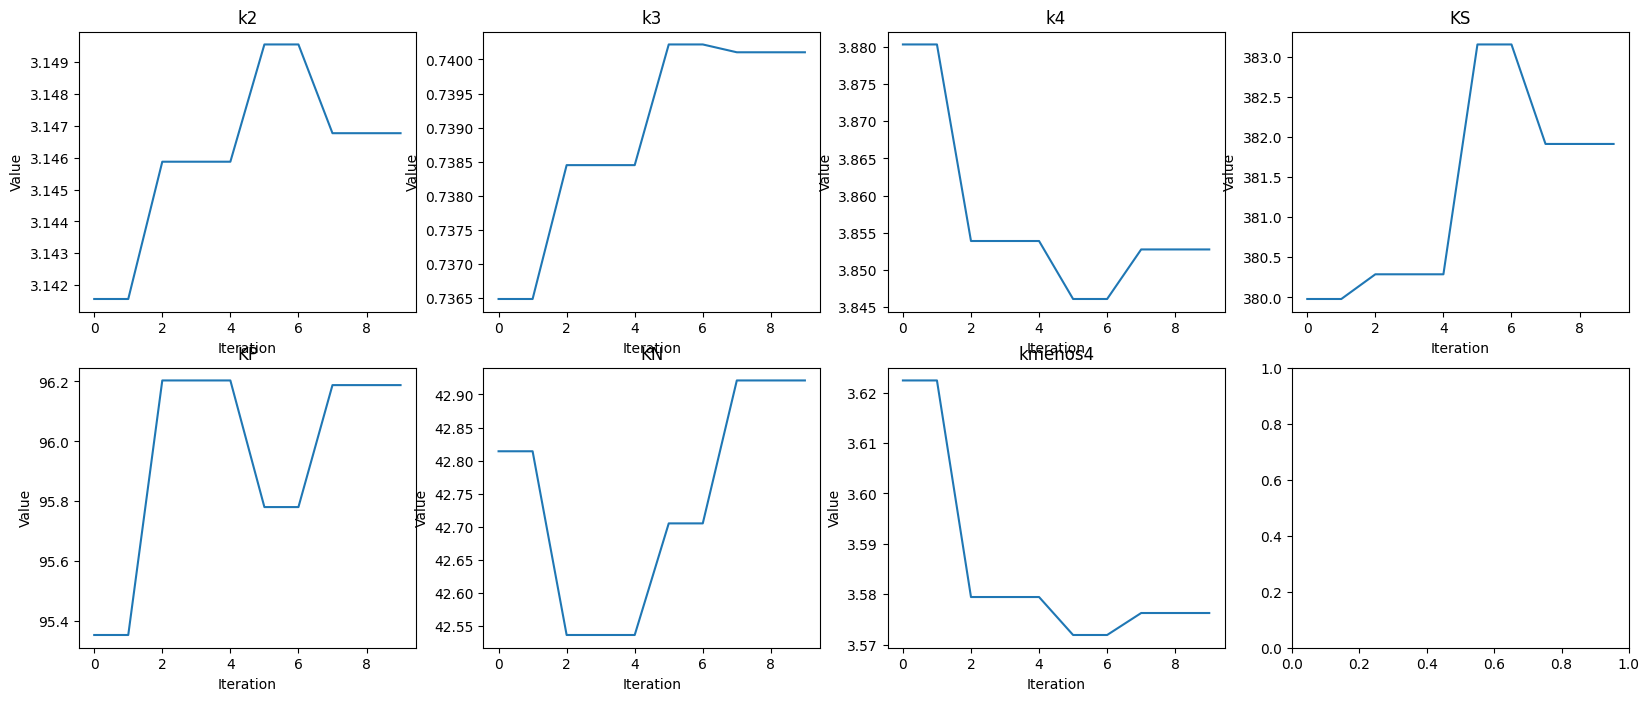

In [11]:
print(data_frames[CIs[3]])
name_teste = 'teste'
ps,aceita = mcmc(data_frames[CIs[3]],P=priori,name=name_teste,N=10,status=True,seed=10)

In [ ]:
import os

Ns = [50000]
num_of_replicates = 3
seed = 0

# Define the log file path
log_file_path = "../results/model_donald/aceitacao_log_adj.txt"

# Ensure the log file exists by creating it if it doesn't exist
if not os.path.exists(log_file_path):
    with open(log_file_path, "w") as f:
        pass

with open(log_file_path, "a") as log_file:
    for curr in range(num_of_replicates):
        for N in Ns:
            all_par_df = pd.DataFrame(np.zeros((len(data_frames),len(labels))),columns=labels)
            all_parstderror_df = pd.DataFrame(np.zeros((len(data_frames),len(labels))),columns=labels)
            count = 0
            for ci,name in zip(CIs,file_list):
                
                print(f'Currently {curr}: {name} {N}')
                Ps,aceitacao = mcmc(data_frames[ci],P=priori,name=f"{curr}_{name}_adj",N=N,status=True,seed=seed)
                np.savez_compressed(f'../results/pickles/donald/{curr}_{N}_{priori_name}_{name}_adj',Ps)
                
                # Log the aceitacao variable
                log_entry = f"{curr}_{N}_{priori_name}_{name}_adj : {aceitacao}\n"
                log_file.write(log_entry)  # Append the formatted entry to the log file
                print('\naceitação: ', aceitacao)
            
                    
                P_conf = pd.DataFrame(Ps)
                P_mean = P_conf.describe().iloc[1,:].to_numpy()
                P_error = P_conf.describe().iloc[2,:].to_numpy() / np.sqrt(P_conf.size)

                for i in range(len(labels)):
                    print(f'{labels[i]}: {P_mean[i]} +- {P_error[i]}')
                
                all_par_df.iloc[count,:] = P_mean
                all_parstderror_df.iloc[count,:] = P_error
                count += 1
                seed +=1

            all_par_df.to_csv(f'../results/model_donald/par_adj/{curr}_{N}_{priori_name}_mean.csv')
            all_parstderror_df.to_csv(f'../results/model_donald/par_adj/{curr}_{N}_{priori_name}_error.csv')

Currently 0: 25.45nh60ab20 50000


In [12]:
Ns = [100000]
num_of_replicates = 3
curr = 0
seed = 30

# Define the log file path
log_file_path = "../results/model_donald/aceitacao_log_adj.txt"

# Ensure the log file exists by creating it if it doesn't exist
if not os.path.exists(log_file_path):
    with open(log_file_path, "w") as f:
        pass

with open(log_file_path, "a") as log_file:
    for curr in range(num_of_replicates):
        for N in Ns:
            all_par_df = pd.DataFrame(np.zeros((len(data_frames),len(labels))),columns=labels)
            all_parstderror_df = pd.DataFrame(np.zeros((len(data_frames),len(labels))),columns=labels)
            count = 0
            for ci,name in zip(CIs,file_list):
                
                print(f'Currently {curr}: {name} {N}')
                Ps,aceitacao = mcmc(data_frames[ci],P=priori,name=f"{curr}_{name}_adj",N=N,status=True,seed=seed)
                np.savez_compressed(f'../results/pickles/donald/{curr}_{N}_{priori_name}_{name}',Ps)
                print('\naceitação: ',aceitacao)
            
                    
                P_conf = pd.DataFrame(Ps)
                P_mean = P_conf.describe().iloc[1,:].to_numpy()
                P_error = P_conf.describe().iloc[2,:].to_numpy() / np.sqrt(P_conf.size)

                for i in range(len(labels)):
                    print(f'{labels[i]}: {P_mean[i]} +- {P_error[i]}')
                
                all_par_df.iloc[count,:] = P_mean
                all_parstderror_df.iloc[count,:] = P_error
                count += 1
                seed +=1

            all_par_df.to_csv(f'../results/model_donald/{curr}_{N}_{priori_name}_mean.csv')
            all_parstderror_df.to_csv(f'../results/model_donald/{curr}_{N}_{priori_name}_error.csv')

Currently 2: 25.45nh60ab20 100000


Progress: 99.900%
aceitação:  0.42435
k2: 0.1638707407814373 +- 4.332284735043826e-05
k3: 0.4133510474563159 +- 0.00012896550354089082
k4: 0.08886154647212836 +- 1.1506308724636023e-05
k5: 0.034890710181277616 +- 6.72343250953788e-06
KS: 43.20741700740343 +- 0.018678236053966867
KP: 19.567223426389727 +- 0.004178307599009752
KN: 11.524839703408096 +- 0.004722624691801747
kmenos4: 4.8010994362726 +- 0.0019610591628166857
Currently 2: 25.46nh30ab30 100000
Progress: 99.900%
aceitação:  0.3961
k2: 0.11572928774094159 +- 3.0303537696079472e-05
k3: 0.8084157114899406 +- 0.00034610674778131256
k4: 0.42516484167438295 +- 0.0002926913332037564
k5: 0.09592607486928033 +- 4.541284473809315e-05
KS: 43.116482278405584 +- 0.03129698188187929
KP: 11.928948394713126 +- 0.006712108596746846
KN: 40.57938596775573 +- 0.015030149062736968
kmenos4: 3.5163765567456076 +- 0.0010203263014808865
Currently 2: 25.47nh5ab80 100000
Progress: 99.900%
aceitação:  0.93196
k2: 3.3233846516860144 +- 0.00218793047736476

C:\Users\artur\AppData\Roaming\Python\Python311\site-packages\scipy\integrate\_ivp\bdf.py:416: RuntimeWarning: invalid value encountered in subtract
  D[order + 2] = d - D[order + 1]


Progress: 99.900%
aceitação:  0.77708
k2: 0.8999582307778411 +- 0.00046351410008772033
k3: 1.2154801817698018 +- 0.00042731505190620015
k4: 0.2722898126665312 +- 0.00023422489368629145
k5: 0.13330429836809496 +- 0.00019822965527452793
KS: 191.22773499641218 +- 0.14249760236687262
KP: 13.41065023270929 +- 0.00683733418111762
KN: 21.010650846560623 +- 0.006025501829512423
kmenos4: 0.32690101083431045 +- 0.00022432902654812318
Currently 2: 5.103nh40ab30 100000
Progress: 99.900%
aceitação:  0.73876
k2: 0.9829937120126782 +- 0.00041971915210609425
k3: 0.694135197162853 +- 0.00041207027943781404
k4: 0.0038471049277704625 +- 2.419047979750159e-06
k5: 0.003245881508249673 +- 3.066785869909964e-06
KS: 264.482821641023 +- 0.10964923114457505
KP: 67.72462999143917 +- 0.038941933647696575
KN: 42.5497643326132 +- 0.016430810284746515
kmenos4: 3.6950502660175086 +- 0.001488322028667418
Currently 2: 5.106nh100ab40 100000
Progress: 99.900%
aceitação:  0.83868
k2: 0.21553338648518863 +- 0.0001637433186

In [ ]:
seed = 43